<a href="https://colab.research.google.com/github/sarmientoj24/EE298/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Lambda, Input, Dense, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Activation, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import os
# Main cell to run
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Implement VAE here

class VAE():
  image_shape = (80, 60, 3)

  def __init__(self, load=False, encoder_h5=None, 
               decoder_h5=None):
    # Build encoder
    # Adopted from https://github.com/YongWookHa/VAE-Keras/blob/master/VAE.py

    if load:
      print("Loading model from h5...")
      self.load_model(encoder_h5, layer_ = 'encoder')
      self.load_model(decoder_h5, layer_ = 'decoder')

    else:
      print("Creating model architecture...")
      # self.encoder_inputs = Input(shape=self.image_shape)
      # filter_dim = 128
      # x = self.encoder_inputs
      # x = Conv2D(int(filter_dim/16), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(int(filter_dim/8), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(int(filter_dim/4), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(int(filter_dim/2), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(filter_dim, kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # # x = GlobalAveragePooling2D()(x)

      # enc_shape = K.int_shape(x)
      # print(enc_shape)
      # # generate latent vector Q(z|X)
      # x = Flatten()(x)
      # x = Dense(64)(x)
      # x = LeakyReLU(0.2)(x)
      # z_mean = Dense(z_dim, name='z_mean')(x)
      # z_log_sigma = Dense(z_dim, name='z_log_sigma')(x)

      # # use reparameterization trick to push the sampling out as input
      # # note that "output_shape" isn't necessary with the TensorFlow backend
      # z = Lambda(self.sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_sigma])

      # # instantiate encoder model
      # self.encoder = Model(self.encoder_inputs, [z_mean, z_log_sigma, z], name='encoder')
      # self.encoder.summary()
      # plot_model(self.encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

      # # Decoder
      # self.latent_inputs = Input(shape=(z_dim,), name='z_sampling')
      # z = Dense(enc_shape[1] * enc_shape[2] * enc_shape[3], activation='relu')(self.latent_inputs)
      # z = Reshape((enc_shape[1], enc_shape[2], enc_shape[3]))(z)
      # z = Conv2DTranspose(int(filter_dim/2), kernel_size=(1, 2), strides=(2,1), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(int(filter_dim/4), kernel_size=(2,2), strides=(2,2), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(int(filter_dim/8), kernel_size=(2,1), strides=(2,2), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(int(filter_dim/16), kernel_size=(2,2), strides=(2,2), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(3, kernel_size=(2,2), strides=(2,2), padding='same')(z)
      # decoder_output = Activation('tanh')(z)

      # # instantiate decoder model
      # self.decoder = Model(self.latent_inputs, decoder_output, name='decoder')
      # self.decoder.summary()
      # plot_model(self.decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

      # # instantiate VAE model
      # outputs = self.decoder(self.encoder(self.encoder_inputs)[2])
      # self.vae = Model(self.encoder_inputs, outputs, name='vae')
      # self.vae.summary()

      #### Meryl Version modified
      z_dim = 10
      kernel_size = 2
      latent_dim = 10
      filter_dims = [8, 16, 32]
      filter_decoder = [32, 16, 8]
      
      self.inputs = Input(shape=self.image_shape, name='encoder_input')
      x = self.inputs
      for i in range(2):
        filters = filter_dims[i]
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=2,
                  padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

      # shape info needed to build decoder model
      shape = K.int_shape(x)

      # generate latent vector Q(z|X)
      x = Flatten()(x)
      x = Dense(64, activation='relu')(x)
      z_mean = Dense(latent_dim, name='z_mean')(x)
      z_log_sigma = Dense(latent_dim, name='z_log_sigma')(x)

      # use reparameterization trick to push the sampling out as input
      # note that "output_shape" isn't necessary with the TensorFlow backend
      z = Lambda(self.sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

      # instantiate encoder model
      self.encoder = Model(self.inputs, [z_mean, z_log_sigma, z], name='encoder')
      self.encoder.summary()
      plot_model(self.encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

      # build decoder model
      self.latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
      x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(self.latent_inputs)
      x = Reshape((shape[1], shape[2], shape[3]))(x)

      for i in range(2):
        filters = filter_decoder[i]
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=2,
                            padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

      outputs = Conv2DTranspose(filters=3,
                                kernel_size=kernel_size,
                                activation='tanh',      # Changed to tanh because data preparation was geared to be [-1, 1]
                                padding='same',
                                name='decoder_output')(x)

      # instantiate decoder model
      self.decoder = Model(self.latent_inputs, outputs, name='decoder')
      self.decoder.summary()
      plot_model(self.decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

      # instantiate VAE model
      outputs = self.decoder(self.encoder(self.inputs)[2])
      self.vae = Model(self.inputs, outputs, name='vae')
      self.vae.summary()

      # Construct the Loss function
      # VAE loss = mse_loss or xent_loss + kl_loss

      reconstruction_loss = mse(K.flatten(self.inputs), K.flatten(outputs))
      # #reconstruction_loss = binary_crossentropy(K.flatten(self.encoder_inputs),
      # #                                           K.flatten(outputs))

      reconstruction_loss *= self.image_shape[0] * self.image_shape[1] * self.image_shape[2]
      kl_loss = 1 + (z_log_sigma ** 2) - K.square(z_mean) - K.exp(z_log_sigma ** 2)
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      vae_loss = K.mean(reconstruction_loss + kl_loss)
      # recon = K.sum(K.binary_crossentropy(K.flatten(outputs), K.flatten(self.encoder_inputs)), axis=1)
      # kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
      # vae_loss = recon + kl
      self.vae.add_loss(vae_loss)
      # self.vae.metrics_tensors.append(reconstruction_loss)
      # self.vae.metrics_names.append("val_loss")
      self.vae.compile(optimizer='adam')

  def get_summary(layer_='vae'):
    if layer_ == 'vae':
      self.vae.summary()

    elif layer == 'decoder':
      self.decoder.summary()

    else:
      self.encoder.summary()
  
  def load_model(self, h5_file, layer_):
    print("Loading h5 ", layer_)
    if layer_ == 'encoder':
      self.encoder = load_model(h5_file)
    else:
      self.decoder = load_model(h5_file)

  def _fit(self, epochs, batch_size, x_train):
    self.history = self.vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1)
    self.vae.save('vae_mnist.h5')
    self.encoder.save('vae_encoder.h5')
    self.decoder.save('vae_decoder.h5')

  def get_history(self):
    return self.history
  
  def plot_loss_function(self):
    # Plot training & validation loss values
    plt.plot(self.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

  def get_encoder_model(self):
    return self.encoder
  
  def get_decoder_model(self):
    return self.decoder
  
  def get_vae_model(self):
    return self.vae
  
  # Sampling to be used in training
  def sampling(self, args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_sigma / 2) * epsilon
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [0]:
# ImageEncoder
# After training VAE, create a new model based of the trained encoder
# for encoding the image samples
class ImageEncoder():
  input_shape = (80, 60, 3)

  def __init__(self, encoder, z_dim=10):
    self.encoder = Model(
        Input(shape=input_shape),
        encoder)
    self.epsilon = K.random_normal(shape=(z_dim, ))
  
  def _encode_sampled(self, input_image):
    z_mean, z_log_sigma, z = self.encoder.predict(input_image)
    # We only need z_mean and z_log_sigma
    return z_mean + K.exp(z_log_sigma / 2) * epsilon
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon
  
  def _encode(self, input_image):
    z_mean, z_log_sigma, z = self.encoder.predict(input_image)
    return z_mean, z_log_sigma

In [0]:
#### HELPER FUNCTIONS
import cv2
import glob, os
import pandas as pd
from PIL import Image
import numpy as np

import imageio
def read_imgs_to_np_from_folder(img_folder):
  cwd = os.getcwd()

  # os.chdir(img_folder + '/')

  imgs = glob.glob(img_folder + '*.jpg')
  # height,width = imageio.imread(imgs[0]).shape[:2]

  X = []
  count = 0
  for f in imgs:
    x = imageio.imread(f)

    if len(x.shape) == 3 and x.shape[0] == 80 and x.shape[1] == 60 and x.shape[2] == 3:
      x = x.astype(np.float32) / 255.0
      X.append(x)
      count += 1
    if count % 10000 == 0:
      print("Traversed ", count)
    
  X = np.array(X)
  print(X.shape)
  return X

##### This function should be in the web-app (REMOVE once completed) ###########
import math
import numpy as np
import operator
# import pandas as pd

# decoder_loaded_model = load_model('decoder.h5')

def compute_log_likelihood(z_gen, mu_, log_sigma):
  # (zi−μi(x))22σi(x)2
  # Adopted here https://datascience.stackexchange.com/questions/64097/how-to-use-variational-autoencoders-%CE%BC-and-%CF%83-with-user-generated-z/64163#64163
  term_a = (z_gen - mu_) ** 2
  term_b = 2 * (log_sigma ** 2)
  term_c = -1 * (term_a / term_b)

  # −log(2π−−√σi(x))
  term_d = np.log(((2 * np.pi) ** 0.5) * (log_sigma))
  term_e = term_c - term_d

  likelihood = np.sum(term_e)
  return likelihood

def find_nearest(z_var_generated):
  # SQL Query get all of those needed and store to dataframe
  # Do Query here
  z_dim = len(z_var_generated)
  z_var_generated = np.array(z_var_generated) # Convert to numpy

  ids_ = sql_df['id'].to_list()
  df = sql_df[['mu_1', 'mu_2', 'mu_3', 'mu_4', 'mu_5', 
               'mu_6', 'mu_7', 'mu_8', 'mu_9', 'mu_10',
               'log_sigma_1', 'log_sigma_2', 'log_sigma_3', 'log_sigma_4', 'log_sigma_5',
               'log_sigma_6', 'log_sigma_7', 'log_sigma_8', 'log_sigma_9', 'log_sigma_10']]
  
  datapoints_encoded_in_db = df.to_numpy()
  rows = datapoints_encoded_in_db.shape[1]

  likelihoods = {}

  counter = 0
  for data in rows:
    mu_vector = data[:z_dim]
    sigma_vector = data[z_dim:z_dim*2]
    log_likelihood = compute_log_likelihood(z_var_generated,
                                            mu_vector, log_sigma_vector)
    likelihoods[id_s[counter]] = log_likelihood
    counter += 1

  # Sort dictionary by likelihood
  sorted_x = sorted(likelihoods.items(), key=operator.itemgetter(1))

  # return top three descending
  return sorted_x[0], sorted_x[1], sorted_x[2]

def decode_img(z_var_generated):
  img = decoder_loaded_model.predict(z_var_generated)
  return img

##########Functions above are to be used inside the web-app locally hosted #########3

# Function to use ENCODER and ENCODE datapoints to database
# Could be run on Colab or PC with GPU/Keras
import sqlite3
def encode_img_from_folder_to_db(folder, db, encoder):
  try:
    conn = sqlite3.connect(db)
  except Error as e:
    print(e)

  conn = self.create_connection(database)

  sql = '''
          SELECT id, image_id
          FROM appchemy_apparel_dummy
        '''

  products_df = pd.read_sql_query(sql, conn)
  image_ids = products_df['image_id'].to_list()

  cwd = os.getcwd()
  img_folder = folder + '/'

  cur = conn.cursor()
  os.chdir(img_folder)

  for index, image_id in enumerate(image_ids):
    img_name = str(image_id) + '.jpg'
    
    try:
        img = cv2.imread(img_name, mode='RGB')
        if img.shape() == (80, 60, 3):
          mu_, log_sigma_ = encoder.__encode(img)      # change if either to store z or mu and log_var

          # Update in db
          sql = '''
                UPDATE appchemy_apparel_dummy SET
                mu_1 = {}, mu_2 = {}, mu_3 = {}, mu_4 = {}, mu_5 = {}, 
                mu_6 = {}, mu_7 = {}, mu_8 = {}, mu_9 = {}, mu_10 = {},
                log_sigma_1 = {}, log_sigma_2 = {}, log_sigma_3 = {}, 
                log_sigma_4 = {}, log_sigma_5 = {}, log_sigma_6 = {}, 
                log_sigma_7 = {}, log_sigma_8 = {}, log_sigma_9 = {}, log_sigma_10 = {}
                WHERE id = {}
              '''.format(mu_[0], mu_[1], mu_[2], mu_[3], mu_[4], mu_[5], 
                         mu_[6], mu_[7], mu_[8], mu_[9], 
                         log_sigma_[0], log_sigma_[1], log_sigma_[2], log_sigma_[3], log_sigma_[4], 
                         log_sigma_[5], log_sigma_[6], log_sigma_[7], log_sigma_[8], log_sigma_[9],
                         image_id)
          cur.execute(sql)
          if index % 200 == 0:
            conn.commit()
          print("File not 80x60x3: ", img_name)
    except:
      print("Error reading file: ", img_name)
      continue

  conn.commit()
  conn.close()


In [0]:
!chmod 600 '/content/drive/My Drive/ee298/dataset.tar.xz'
!cp '/content/drive/My Drive/ee298/dataset.tar.xz' '/content/data_im/'

In [0]:
!tar -xf '/content/data_im/dataset.tar.xz'

In [7]:
x_train = read_imgs_to_np_from_folder('/content/apparel_reduced/')

Traversed  10000
Traversed  20000
Traversed  30000
Traversed  40000
Traversed  50000
Traversed  60000
Traversed  70000
Traversed  80000
Traversed  90000
(92013, 80, 60, 3)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 80, 60, 3)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 40, 30, 16)   208         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 40, 30, 16)   64          conv2d_3[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 40, 30, 16)   0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

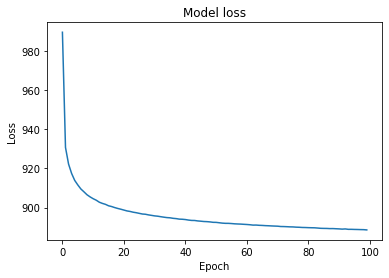

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z_dim = 16
kernel_size = 2
latent_dim = 16
filter_dims = [16, 32, 64]
filter_decoder = [64, 32, 16]
image_shape = (80, 60, 3)
epochs = 100
batch_size=32
from keras import layers, initializers
from keras.layers import Dropout

inputs = Input(shape=image_shape, name='encoder_input')
x = inputs
for i in range(2):
  filters = filter_dims[i]
  x = Conv2D(filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.1)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(64)(x)
x = LeakyReLU(0.1)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var',
      kernel_initializer='glorot_normal',
      bias_initializer=initializers.Constant(0.1))(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(64)(latent_inputs)
x = LeakyReLU(0.1)(x)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = LeakyReLU(0.1)(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
  filters = filter_decoder[i]
  x = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.1)(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

# Construct the Loss function
# VAE loss = mse_loss or xent_loss + kl_loss

# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                           K.flatten(outputs))

reconstruction_loss *= image_shape[0] * image_shape[1]
# reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + (z_log_var) - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# recon = K.sum(K.binary_crossentropy(K.flatten(inputs), K.flatten(outputs)))
# kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
# vae_loss = recon + kl

# vae.metrics_tensors.append(reconstruction_loss)
# vae.metrics_names.append("val_loss")

# translate our loss into Keras code
# def vae_loss(y_true, y_pred):
#     """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
#     recon = K.sum(K.binary_crossentropy(y_true, y_pred))
#     kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
#     return recon + kl
vae.add_loss(vae_loss)
# es = EarlyStopping(monitor='vae_loss', mode='min', verbose=1, patience=20)
vae.compile(optimizer='adam')

history = vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1)
vae.save('vae_binary_cross_adam_epoch_only_relu_200.h5')
encoder.save('encoder_binary_cross_adam_epoch_only_relu_200.h5')
decoder.save('decoder_binary_cross_adam_epoch_only_relu_200.h5')

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# plt.plot(history.history['accuracy'])
# plt.title('Model Acc')
# plt.ylabel('Acc')
# plt.xlabel('Epoch')
# plt.show()

/content/apparel_reduced/70666.jpg
(80, 60, 3)


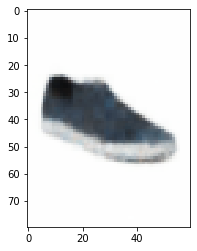

In [11]:
imgs = glob.glob('/content/apparel_reduced/' + '*.jpg')
img_1 = imgs[0]
print(img_1)
img_1 = '/content/29570.jpg'    # benchmarking on a specific image
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 80, 60, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

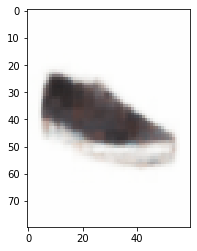

In [0]:
'''
Basically, we cannot serialize custom losses.
Knowing that loss functions arent really used for predicting (this time, decoding),
we could just pass any fake loss function.
Model cannot be loaded without the custom loss being initialized.

'''
def fake_loss(y_true, y_pred):
  reconstruction_loss = binary_crossentropy(K.flatten(y_true),
                                           K.flatten(y_pred))
  return reconstruction_loss

vae_loaded = load_model('/content/vae_binary_cross_adam_epoch_only_relu_200.h5', compile=False)
vae_loaded.compile(loss=fake_loss, optimizer='adam')
out_vae2 = vae_loaded.predict(x)
plt.imshow(out_vae2[0])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20,)
(20, 1)


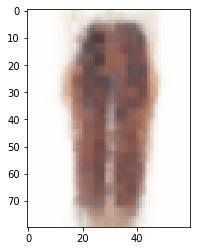

In [0]:
'''
Basically, we cannot serialize custom losses.
Knowing that loss functions arent really used for predicting (this time, decoding),
we could just pass any fake loss function.
Model cannot be loaded without the custom loss being initialized.

'''
def fake_loss(y_true, y_pred):
  reconstruction_loss = binary_crossentropy(K.flatten(y_true),
                                           K.flatten(y_pred))
  return reconstruction_loss

decoder_loaded = load_model('/content/vae_decoder2.h5')

z_fake = np.random.normal(size=(20,))
z_fake = z_fake.reshape(-1, 20)
out_vae2 = decoder_loaded.predict(np.array(z_fake))

plt.imshow(out_vae2[0])

In [0]:
z_fake = np.random.normal(size=(20,))
print(z_fake.shape)
print(z_fake.reshape(-1, 10))

(20,)
[[ 1.05258615 -1.51580388 -0.43529676  1.02614883  0.4022439   0.05051422
   0.61864525 -0.0969342   1.56586018  0.23436775]
 [-0.44126733  0.55339449  1.75315197 -0.62364104 -0.071452    0.10680854
  -0.28578064 -1.18017206  0.73113178  0.44950148]]


In [0]:
fake_predicted = decoder.predict(z_fake.reshape(-1, 20))

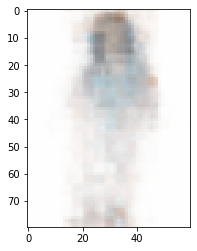

In [0]:
plt.imshow(fake_predicted[0])

In [0]:
#### For encoding
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

class Visualizer():
  def __init__(self):
    pass

class ClusterGenerator():
  def __init__(self, k):
    self.k = k

  def generate_cluster(self, product_df):
    kmeans = KMeans(n_clusters=self.k, max_iter=1000).fit(product_df[[
            'latent_code1', 'latent_code2', 'latent_code3',
            'latent_code4', 'latent_code5'
    ]])

    centroids = kmeans.cluster_centers_
    return kmeans.labels_, kmeans.cluster_centers_

    # # Import the KElbowVisualizer method 
    # from yellowbrick.cluster import KElbowVisualizer
    # # Instantiate a scikit-learn K-Means model
    # model = KMeans(random_state=0)
    # # Instantiate the KElbowVisualizer with the number of clusters and the metric 
    # visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)
    # # Fit the data and visualize
    # visualizer.fit(X)    
    # visualizer.poof() 

class Apparel():
  def __init__(self):
    pass

class Apparels():
  def __init__(self):
    self.db_file = "db.sqlite3"
    self.products_df = None

  def connect_to_db(self):
    conn = None
    try:
      conn = sqlite3.connect(self.db_file)
    except Exception as e:
      print(str(e))
    return conn

  def get_products_from_db(self):
    print("Getting products from db...")
    conn = self.connect_to_db()

    sql = '''
            SELECT id, latent_code1, latent_code2, latent_code3,
            latent_code4, latent_code5 
            FROM appchemy_apparel_dummy
          '''
    self.products_df = pd.read_sql_query(sql, conn)
    conn.close()
  
  def get_products_df(self):
    return self.products_df
  
  def set_products_df(self, products_df):
    self.products_df = products_df
  
  def insert_clusters_to_df(self, cluster_labels):
    self.products_df['cluster_id'] = cluster_labels
  
  def df_to_csv(self, filename):
    self.products_df.to_csv(filename)
  
  def insert_cluster_label_to_db(self, cluster_labels):
    print("Inserting Cluster Labels...")
    conn = self.connect_to_db()
    cur = conn.cursor()

    product_ids = self.products_df['id'].to_list()

    for index, cluster_label in enumerate(cluster_labels):
      sql = '''
              UPDATE appchemy_apparel_dummy SET cluster_id = {} WHERE id = {}
            '''.format(int(cluster_label), product_ids[index])
      cur.execute(sql)
    conn.commit()
    cur.close()
  
  def insert_cluster_centroids(self, cluser_centroids, create_table=False):
    print("Inserting cluster centroids...")
    conn = self.connect_to_db()
    cur = conn.cursor()

    if create_table:
      sql = "DROP TABLE IF EXISTS appchemy"
      cur.execute(sql)
      conn.commit()

      sql = '''
              CREATE table cluster_centroids (
                id INTEGER,
                name TEXT,
                latent_code1 REAL,
                latent_code2 REAL,
                latent_code3 REAL,
                latent_code4 REAL,
                latent_code5 REAL
              ) 
            '''
      cur.execute(sql)
      conn.commit()

    for index, cluster_centroid in enumerate(cluster_centroids):
      data_ = cluster_centroid.tolist()
      sql = '''
              INSERT INTO appchemy_cluster_test (latent_code1, latent_code2, latent_code3,
              latent_code4, latent_code5, cluster_id) VALUES (?, ?, ?, ?, ?, ?)
            '''.format(index)
      cur.execute(sql, (float(data_[0]), data_[1], data_[2],
                        data_[3], data_[4], index))
    conn.commit()
    conn.close()

################# UTIL CLASS #####################
class DBUtil():
  def create_connection(self, db_file):
      """ create a database connection to the SQLite database
          specified by db_file
      :param db_file: database file
      :return: Connection object or None
      """
      conn = None
      try:
          conn = sqlite3.connect(db_file)
      except Error as e:
          print(e)
      return conn

  def drop_tbl(self, table_name):
    database = "db.sqlite3"
    conn = self.create_connection(database)

    sql = "DROP TABLE {}".format(table_name)
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()
    conn.close()

  def create_encoded_table(self):
    database = "db.sqlite3"
    conn = self.create_connection(database)

    sql = '''
           CREATE TABLE product_entries (
                id INTEGER,
                name TEXT,
                old_name TEXT,
                cluster_id INTEGER,
                subcategory TEXT,
                z_mean_1 REAL, z_log_var_1 REAL, z_fixed_code_1 REAL,
                z_mean_2 REAL, z_log_var_2 REAL, z_fixed_code_2 REAL,
                z_mean_3 REAL, z_log_var_3 REAL, z_fixed_code_3 REAL, 
                z_mean_4 REAL, z_log_var_4 REAL, z_fixed_code_4 REAL,
                z_mean_5 REAL, z_log_var_5 REAL, z_fixed_code_5 REAL,
                z_mean_6 REAL, z_log_var_6 REAL, z_fixed_code_6 REAL,
                z_mean_7 REAL, z_log_var_7 REAL, z_fixed_code_7 REAL,
                z_mean_8 REAL, z_log_var_8 REAL, z_fixed_code_8 REAL,
                z_mean_9 REAL, z_log_var_9 REAL, z_fixed_code_9 REAL,
                z_mean_10 REAL, z_log_var_10 REAL, z_fixed_code_10 REAL,
                z_mean_11 REAL, z_log_var_11 REAL, z_fixed_code_11 REAL,
                z_mean_12 REAL, z_log_var_12 REAL, z_fixed_code_12 REAL,
                z_mean_13 REAL, z_log_var_13 REAL, z_fixed_code_13 REAL,
                z_mean_14 REAL, z_log_var_14 REAL, z_fixed_code_14 REAL,
                z_mean_15 REAL, z_log_var_15 REAL, z_fixed_code_15 REAL,
                z_mean_16 REAL, z_log_var_16 REAL, z_fixed_code_16 REAL
              ) 
          '''
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()
    conn.close()

  def cluster_table(self):
    database = "db.sqlite3"
    conn = self.create_connection(database)

    sql = '''
           CREATE TABLE cluster_centroids (
                id INTEGER,
                cluster_id INTEGER,
                xtra_field TEXT,
                z_mean_1 REAL, z_log_var_1 REAL, z_fixed_code_1 REAL,
                z_mean_2 REAL, z_log_var_2 REAL, z_fixed_code_2 REAL,
                z_mean_3 REAL, z_log_var_3 REAL, z_fixed_code_3 REAL, 
                z_mean_4 REAL, z_log_var_4 REAL, z_fixed_code_4 REAL,
                z_mean_5 REAL, z_log_var_5 REAL, z_fixed_code_5 REAL,
                z_mean_6 REAL, z_log_var_6 REAL, z_fixed_code_6 REAL,
                z_mean_7 REAL, z_log_var_7 REAL, z_fixed_code_7 REAL,
                z_mean_8 REAL, z_log_var_8 REAL, z_fixed_code_8 REAL,
                z_mean_9 REAL, z_log_var_9 REAL, z_fixed_code_9 REAL,
                z_mean_10 REAL, z_log_var_10 REAL, z_fixed_code_10 REAL,
                z_mean_11 REAL, z_log_var_11 REAL, z_fixed_code_11 REAL,
                z_mean_12 REAL, z_log_var_12 REAL, z_fixed_code_12 REAL,
                z_mean_13 REAL, z_log_var_13 REAL, z_fixed_code_13 REAL,
                z_mean_14 REAL, z_log_var_14 REAL, z_fixed_code_14 REAL,
                z_mean_15 REAL, z_log_var_15 REAL, z_fixed_code_15 REAL,
                z_mean_16 REAL, z_log_var_16 REAL, z_fixed_code_16 REAL
              ) 
          '''

    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()
    conn.close()

  def insert_dummy_data_to_sqlite(self):
    database = "db.sqlite3"
    conn = self.create_connection(database)

    sql = '''
            SELECT id
            FROM appchemy_apparel_dummy
          '''
    products_df = pd.read_sql_query(sql, conn)
    ids = products_df['id'].to_list()

    latent_code1 = np.random.uniform(-2, 2, size=(len(ids),))
    latent_code2 = np.random.uniform(-2, 2, size=(len(ids),))
    latent_code3 = np.random.uniform(-2, 2, size=(len(ids),))
    latent_code4 = np.random.uniform(-2, 2, size=(len(ids),))
    latent_code5 = np.random.uniform(-2, 2, size=(len(ids),))
    
    cur = conn.cursor()
    
    for index in range(len(ids)):
      sql = '''
            UPDATE appchemy_apparel_dummy SET latent_code1 = {}, 
            latent_code2 = {}, latent_code3 = {},
            latent_code4 = {}, latent_code5 = {} WHERE id = {}
          '''.format(latent_code1[index], latent_code2[index], 
              latent_code3[index], latent_code4[index], latent_code5[index],
              ids[index])
      cur.execute(sql)
      if index % 200 == 0:
        conn.commit()
    conn.commit()
    conn.close()

################ PROGRAM START ###################
# prod = Apparels()
# cluster_gen = ClusterGenerator(k=5)

# prod.get_products_from_db()




In [0]:
################# UTIL CLASS #####################
# x = DBUtil()
# x.cluster_table()

In [0]:
# Encoder funcs
import cv2
import glob, os
import pandas as pd
from PIL import Image
import numpy as np
import imageio
from keras import layers, initializers

class ImgEncoder():
  input_shape = (80, 60, 3)
  def __init__(self, encoder_name=None, z_dim=16, load=False, encoder_model=None):
    if load:
      # Rebuild
      inputs = Input(shape=self.input_shape, name='encoder_input')
      x = inputs
      kernel_size = 2
      filter_dims = [16, 32, 64]
      for i in range(2):
        filters = filter_dims[i]
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=2,
                  padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x)
      x = Flatten()(x)
      x = Dense(64)(x)
      x = LeakyReLU(0.1)(x)

      z_mean = Dense(z_dim, name='z_mean')(x)
      z_log_var = Dense(z_dim, name='z_log_var',
            kernel_initializer='glorot_normal',
            bias_initializer=initializers.Constant(0.1))(x)

      # use reparameterization trick to push the sampling out as input
      # note that "output_shape" isn't necessary with the TensorFlow backend
      z = Lambda(self.sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

      # instantiate encoder model
      self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
      self.encoder.load_weights(encoder_name)
    else:
      self.encoder = encoder_model
    self.epsilon = K.random_normal(shape=(z_dim, ))
  
  def sampling(self, args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

  # Fixed epsilon sampling, we get z_mean, z_log_var, and z_new for everything
  # Same epsilon sampling for everyone to get discrete z_new
  def encode_sampled(self, input_image):
    # x = imageio.imread(input_image)
    # x = x.astype(np.float32) / 255.0
    # x = np.reshape(x, [-1, 80, 60, 3])
    z_mean, z_log_var, z = self.encoder.predict(x)
    z_new = z_mean + K.exp(z_log_var / 2) * epsilon
    return z_mean, z_log_var, z_new

  def read_imgs_to_np_from_folder(self):
    cwd = os.getcwd()
    # os.chdir(img_folder + '/')
    imgs = glob.glob("/content/apparel_reduced/" + '*.jpg')
    X = []
    file_names = []
    count = 0
    for f in imgs:
      x = imageio.imread(f)

      if len(x.shape) == 3 and x.shape[0] == 80 and x.shape[1] == 60 and x.shape[2] == 3:
        x = x.astype(np.float32) / 255.0
        X.append(x)
        count += 1
        file_names.append(int(f.replace('.jpg', '').replace('/content/apparel_reduced/', '')))

      if count % 10000 == 0:
        print("Collected ", count)
    X = np.array(X)

    data_ = {
        'name': file_names
    }

    data_fr = pd.DataFrame.from_dict(data_)
    return X, data_fr

    def encode_all(self, img_data, data_frame):
      z_mean_1 = []
      z_mean_2 = []
      z_mean_3 = []
      z_mean_4 = []
      z_mean_5 = []
      z_mean_6 = []
      z_mean_7 = []
      z_mean_8 = []
      z_mean_9 = []
      z_mean_10 = []
      z_mean_11 = []
      z_mean_12 = []
      z_mean_13 = []
      z_mean_14 = []
      z_mean_15 = []
      z_mean_16 = []
      z_log_var_1 = []
      z_log_var_2 = []
      z_log_var_3 = []
      z_log_var_4 = []
      z_log_var_5 = []
      z_log_var_6 = []
      z_log_var_7 = []
      z_log_var_8 = []
      z_log_var_9 = []
      z_log_var_10 = []
      z_log_var_11 = []
      z_log_var_12 = []
      z_log_var_13 = []
      z_log_var_14 = []
      z_log_var_15 = []
      z_log_var_16 = []
      z_fixed_code_1 = []
      z_fixed_code_2 = []
      z_fixed_code_3 = []
      z_fixed_code_4 = []
      z_fixed_code_5 = []
      z_fixed_code_6 = []
      z_fixed_code_7 = []
      z_fixed_code_8 = []
      z_fixed_code_9 = []
      z_fixed_code_10 = []
      z_fixed_code_11 = []
      z_fixed_code_12 = []
      z_fixed_code_13 = []
      z_fixed_code_14 = []
      z_fixed_code_15 = []
      z_fixed_code_16 = []
      image_names = data_frame['name'].to_list()

      count = 0
      for img_d in img_data:
        z_mean, z_log_var, z_fixed_code = self.encode_sampled(img_d)
        z_mean_1.append(z_mean[0])
        z_mean_2.append(z_mean[1])
        z_mean_3.append(z_mean[2])
        z_mean_4.append(z_mean[3])
        z_mean_5.append(z_mean[4])
        z_mean_6.append(z_mean[5])
        z_mean_7.append(z_mean[6])
        z_mean_8.append(z_mean[7])
        z_mean_9.append(z_mean[8])
        z_mean_10.append(z_mean[9])
        z_mean_11.append(z_mean[10])
        z_mean_12.append(z_mean[11])
        z_mean_13.append(z_mean[12])
        z_mean_14.append(z_mean[13])
        z_mean_15.append(z_mean[14])
        z_mean_16.append(z_mean[15])
        z_log_var_1.append(z_log_var[0])
        z_log_var_2.append(z_log_var[1])
        z_log_var_3.append(z_log_var[2])
        z_log_var_4.append(z_log_var[3])
        z_log_var_5.append(z_log_var[4])
        z_log_var_6.append(z_log_var[5])
        z_log_var_7.append(z_log_var[6])
        z_log_var_8.append(z_log_var[7])
        z_log_var_9.append(z_log_var[8])
        z_log_var_10.append(z_log_var[9])
        z_log_var_11.append(z_log_var[10])
        z_log_var_12.append(z_log_var[11])
        z_log_var_13.append(z_log_var[12])
        z_log_var_14.append(z_log_var[13])
        z_log_var_15.append(z_log_var[14])
        z_log_var_16.append(z_log_var[15])
        z_fixed_code_1.append(z_fixed_code[0])
        z_fixed_code_2.append(z_fixed_code[1])
        z_fixed_code_3.append(z_fixed_code[2])
        z_fixed_code_4.append(z_fixed_code[3])
        z_fixed_code_5.append(z_fixed_code[4])
        z_fixed_code_6.append(z_fixed_code[5])
        z_fixed_code_7.append(z_fixed_code[6])
        z_fixed_code_8.append(z_fixed_code[7])
        z_fixed_code_9.append(z_fixed_code[8])
        z_fixed_code_10.append(z_fixed_code[9])
        z_fixed_code_11.append(z_fixed_code[10])
        z_fixed_code_12.append(z_fixed_code[11])
        z_fixed_code_13.append(z_fixed_code[12])
        z_fixed_code_14.append(z_fixed_code[13])
        z_fixed_code_15.append(z_fixed_code[14])
        z_fixed_code_16.append(z_fixed_code[15])

        count += 1
        if count % 10000:
          print("Encoded ", count)
      
      data_ = {
          'name': image_names,
          'z_mean_1' : z_mean_1,
          'z_mean_2' : z_mean_2,
          'z_mean_3' : z_mean_3,
          'z_mean_4' : z_mean_4,
          'z_mean_5' : z_mean_5,
          'z_mean_6' : z_mean_6,
          'z_mean_7' : z_mean_7,
          'z_mean_8' : z_mean_8,
          'z_mean_9' : z_mean_9,
          'z_mean_10' : z_mean_10,
          'z_mean_11' : z_mean_11,
          'z_mean_12' : z_mean_12,
          'z_mean_13' : z_mean_13,
          'z_mean_14' : z_mean_14,
          'z_mean_15' : z_mean_15,
          'z_mean_16' : z_mean_16,
          'z_log_var_1' : z_log_var_1,
          'z_log_var_2' : z_log_var_2,
          'z_log_var_3' : z_log_var_3,
          'z_log_var_4' : z_log_var_4,
          'z_log_var_5' : z_log_var_5,
          'z_log_var_6' : z_log_var_6,
          'z_log_var_7' : z_log_var_7,
          'z_log_var_8' : z_log_var_8,
          'z_log_var_9' : z_log_var_9,
          'z_log_var_10' : z_log_var_10,
          'z_log_var_11' : z_log_var_11,
          'z_log_var_12' : z_log_var_12,
          'z_log_var_13' : z_log_var_13,
          'z_log_var_14' : z_log_var_14,
          'z_log_var_15' : z_log_var_15,
          'z_log_var_16' : z_log_var_16,
          'z_fixed_code_1' : z_fixed_code_1,
          'z_fixed_code_2' : z_fixed_code_2,
          'z_fixed_code_3' : z_fixed_code_3,
          'z_fixed_code_4' : z_fixed_code_4,
          'z_fixed_code_5' : z_fixed_code_5,
          'z_fixed_code_6' : z_fixed_code_6,
          'z_fixed_code_7' : z_fixed_code_7,
          'z_fixed_code_8' : z_fixed_code_8,
          'z_fixed_code_9' : z_fixed_code_9,
          'z_fixed_code_10' : z_fixed_code_10,
          'z_fixed_code_11' : z_fixed_code_11,
          'z_fixed_code_12' : z_fixed_code_12,
          'z_fixed_code_13' : z_fixed_code_13,
          'z_fixed_code_14' : z_fixed_code_14,
          'z_fixed_code_15' : z_fixed_code_15,
          'z_fixed_code_16' : z_fixed_code_16
      }

    product_df_code = pd.DataFrame.from_dict(data_)
    return product_df_code

In [19]:
images_encoder = ImgEncoder(encoder_name="/content/encoder_binary_cross_adam_epoch_only_relu_200.h5", load=True, encoder_model=None)
x_data, data_fr = images_encoder.read_imgs_to_np_from_folder()
product_codes_df = images_encoder.encode_all(data_fr, x_data)
del x_data
del data_fr


Collected  10000


KeyboardInterrupt: ignored